In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement # station,date,prcp,tobs
Station = Base.classes.station # station,name,latitude,longitude,elevation

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Grab last date from selected date range
last_date = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()[0]

# Convert object type
entered_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
entered_date = entered_date.date()

# Calculate the date 1 year ago from the last data point in the database
yr_ago = entered_date - dt.timedelta(days=365)
yr_ago

# Perform a query to retrieve the data and precipitation scores
one_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yr_ago).\
    filter(Measurement.date <= last_date).all()

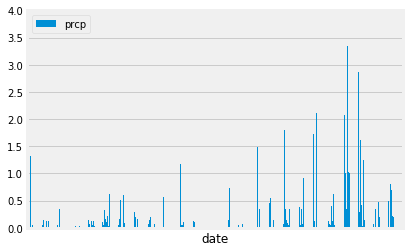

In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(one_year_prcp, columns=['date', 'prcp'])
df.set_index('date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar()
plt.xticks([])
plt.ylim(0,4)
# plt.savefig('.png')
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Query how many stations are available in this dataset
station_ct = session.query(Measurement.station).distinct().count()
print("Station Count:", station_ct)

Station Count: 9


In [24]:
# List most active stations (stations with the most rows of data) in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Data Count'])
active_stations_df

,Station,Data Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station
most_active_station = active_stations[0][0]

most_active_station_tobs = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station==most_active_station).all()[0]

print(f"Temperature Minimum: {most_active_station_tobs[0]}")
print(f"Temperature Average: {most_active_station_tobs[1]}")
print(f"Temperature Maximum: {most_active_station_tobs[2]}")


Temperature Minimum: 54.0
Temperature Average: 71.66378066378067
Temperature Maximum: 85.0


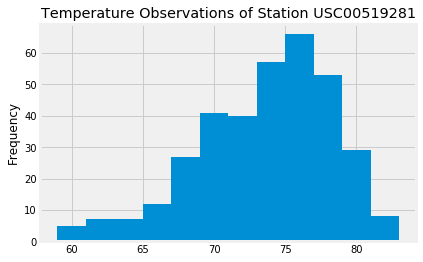

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stn_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date >= yr_ago).\
    filter(Measurement.date <= last_date).\
    filter(Measurement.station==most_active_station).all()

tobs_array = np.ravel(stn_tobs)
tobs_series = pd.Series(tobs_array)

tobs_series.plot.hist(bins=12)
plt.title("Temperature Observations of Station USC00519281")
# plt.savefig('.png')
plt.show()


In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-06-10', '2017-06-25')[0]

print(f"Temperature Minimum: {temps[0]}")
print(f"Temperature Average: {temps[1]}")
print(f"Temperature Maxiumum: {temps[2]}")

Temperature Minimum: 71.0
Temperature Average: 76.8
Temperature Maxiumum: 83.0


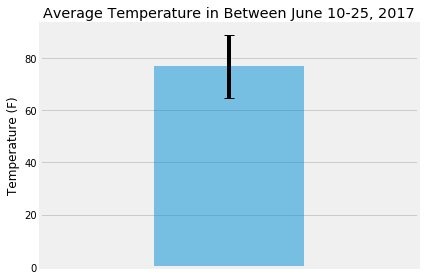

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = temps[1]
yerr = temps[2] - temps[0]

fig, ax = plt.subplots()
ax.bar(1, y, yerr=yerr, align='center', alpha=0.5, capsize=5)
ax.set_ylabel('Temperature (F)')
ax.set_title('Average Temperature in Between June 10-25, 2017')
ax.set_xlim(0,2)
ax.set_xticks([])
plt.tight_layout()
# plt.savefig('.png')
plt.show()

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_dt = dt.datetime(2017, 6, 10)
end_dt = dt.datetime(2017, 6, 25)

trip_dates = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date>=start_dt).\
    filter(Measurement.date<=end_dt).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

trip_df = pd.DataFrame(trip_dates, columns=['station', 'prcp', 'name', 'latitude', 'longitude', 'elevation'])
trip_df



,station,prcp,name,latitude,longitude,elevation
0,USC00516128,8.07,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,3.19,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,2.15,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,1.68,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519523,0.54,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.23,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
